У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [23]:
import pandas as pd

stores_df = pd.read_csv('csv/train.csv.zip', compression='zip')

stores_df['date'] = pd.to_datetime(stores_df['date'], format='%Y-%m-%d', errors='coerce')

stores_df.set_index('date', inplace=True)

print(stores_df.info())
print(stores_df.head())
print(stores_df.index)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB
None
            store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10
DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name=

  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



In [10]:
stores_df.groupby('item').agg(
    count=('item', 'count'),
    total_stores=('store', 'nunique'),
    total_sales=('sales', 'sum')
).sort_index()

,count,total_stores,total_sales
item,,,
1,18260,10,401384
2,18260,10,1069564
3,18260,10,669087
4,18260,10,401907
5,18260,10,335230
6,18260,10,1068281
7,18260,10,1068777
8,18260,10,1405108
9,18260,10,938379


***I want to build plot for 5 best selling items across all stores***

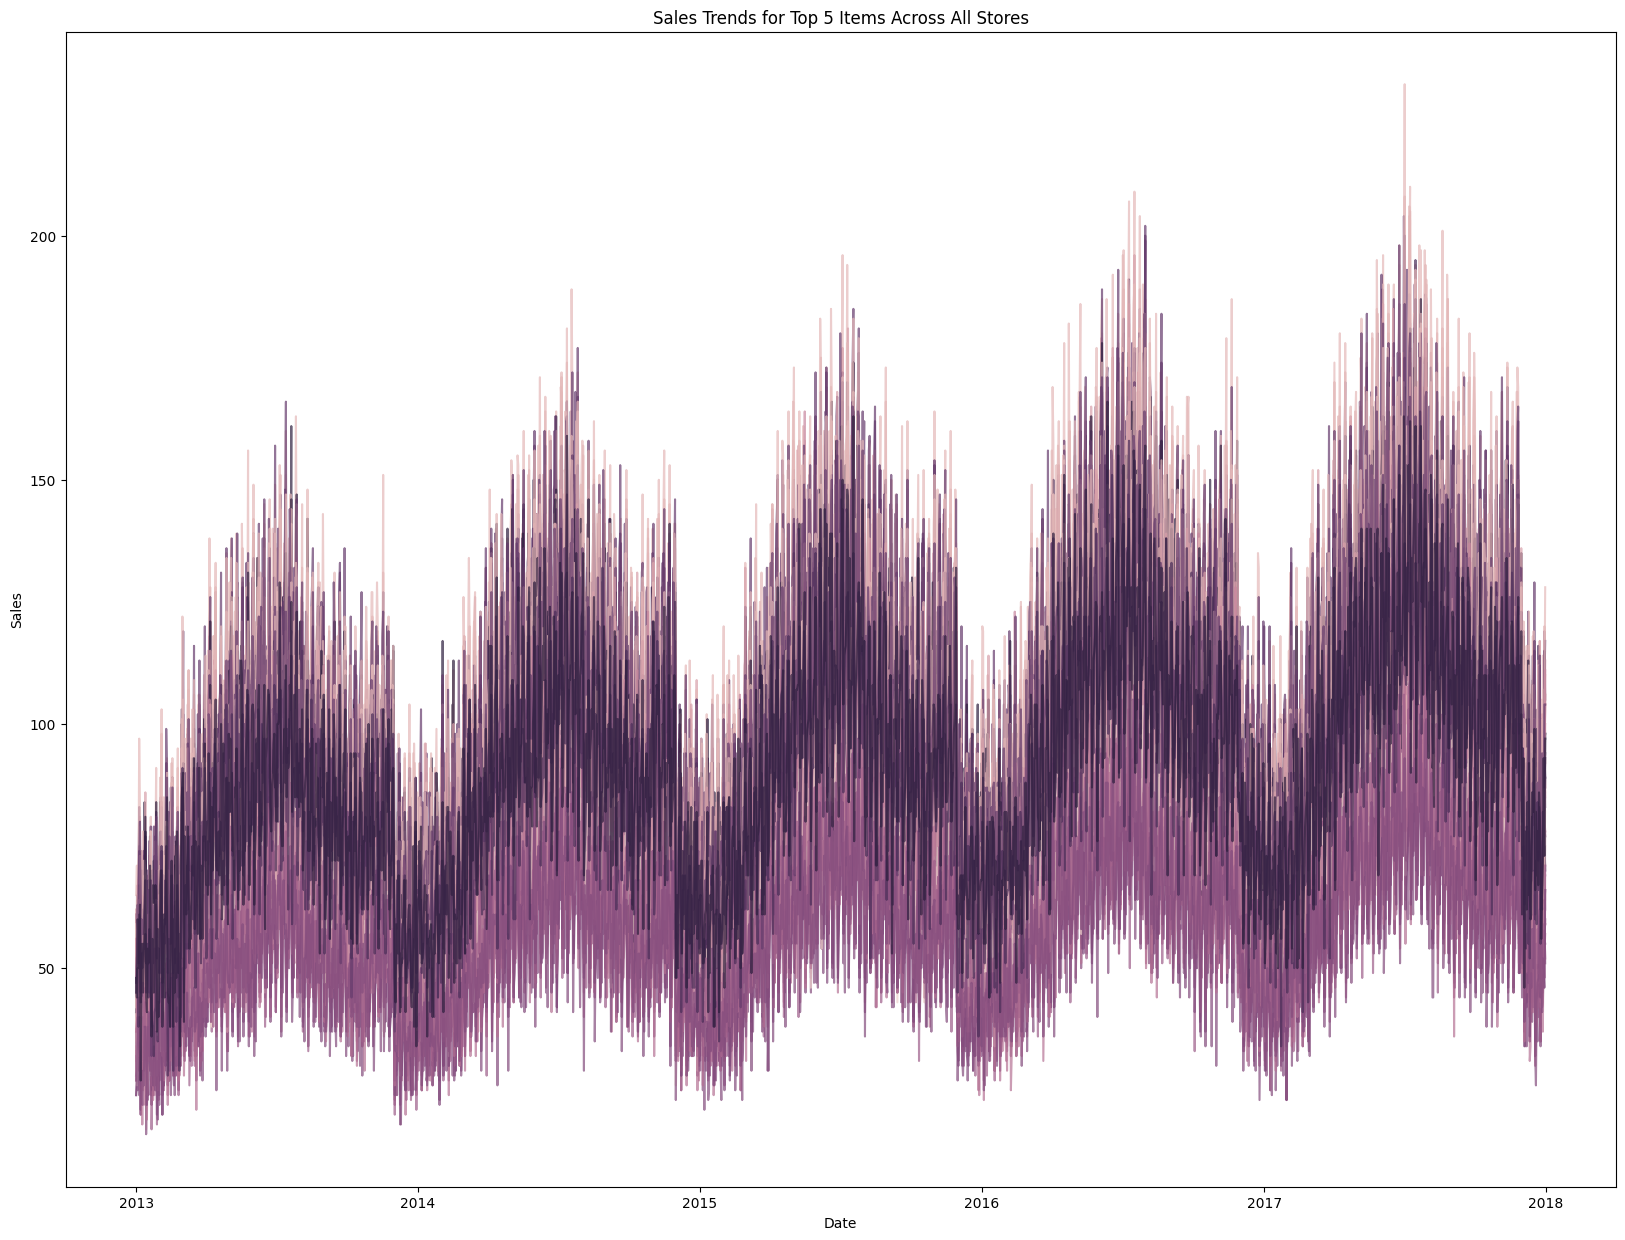

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

top_items = stores_df.groupby('item')['sales'].sum().nlargest(5).index

plt.figure(figsize=(20, 15))

for item in top_items:
    temp_df = stores_df[stores_df['item'] == item]
    sns.lineplot(data=temp_df, x='date', y='sales', hue='store', alpha=.7, linewidth=1.5, legend=False)

plt.title('Sales Trends for Top 5 Items Across All Stores')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

***Let's also build Plot af average sales per item with Confidence Intervals***

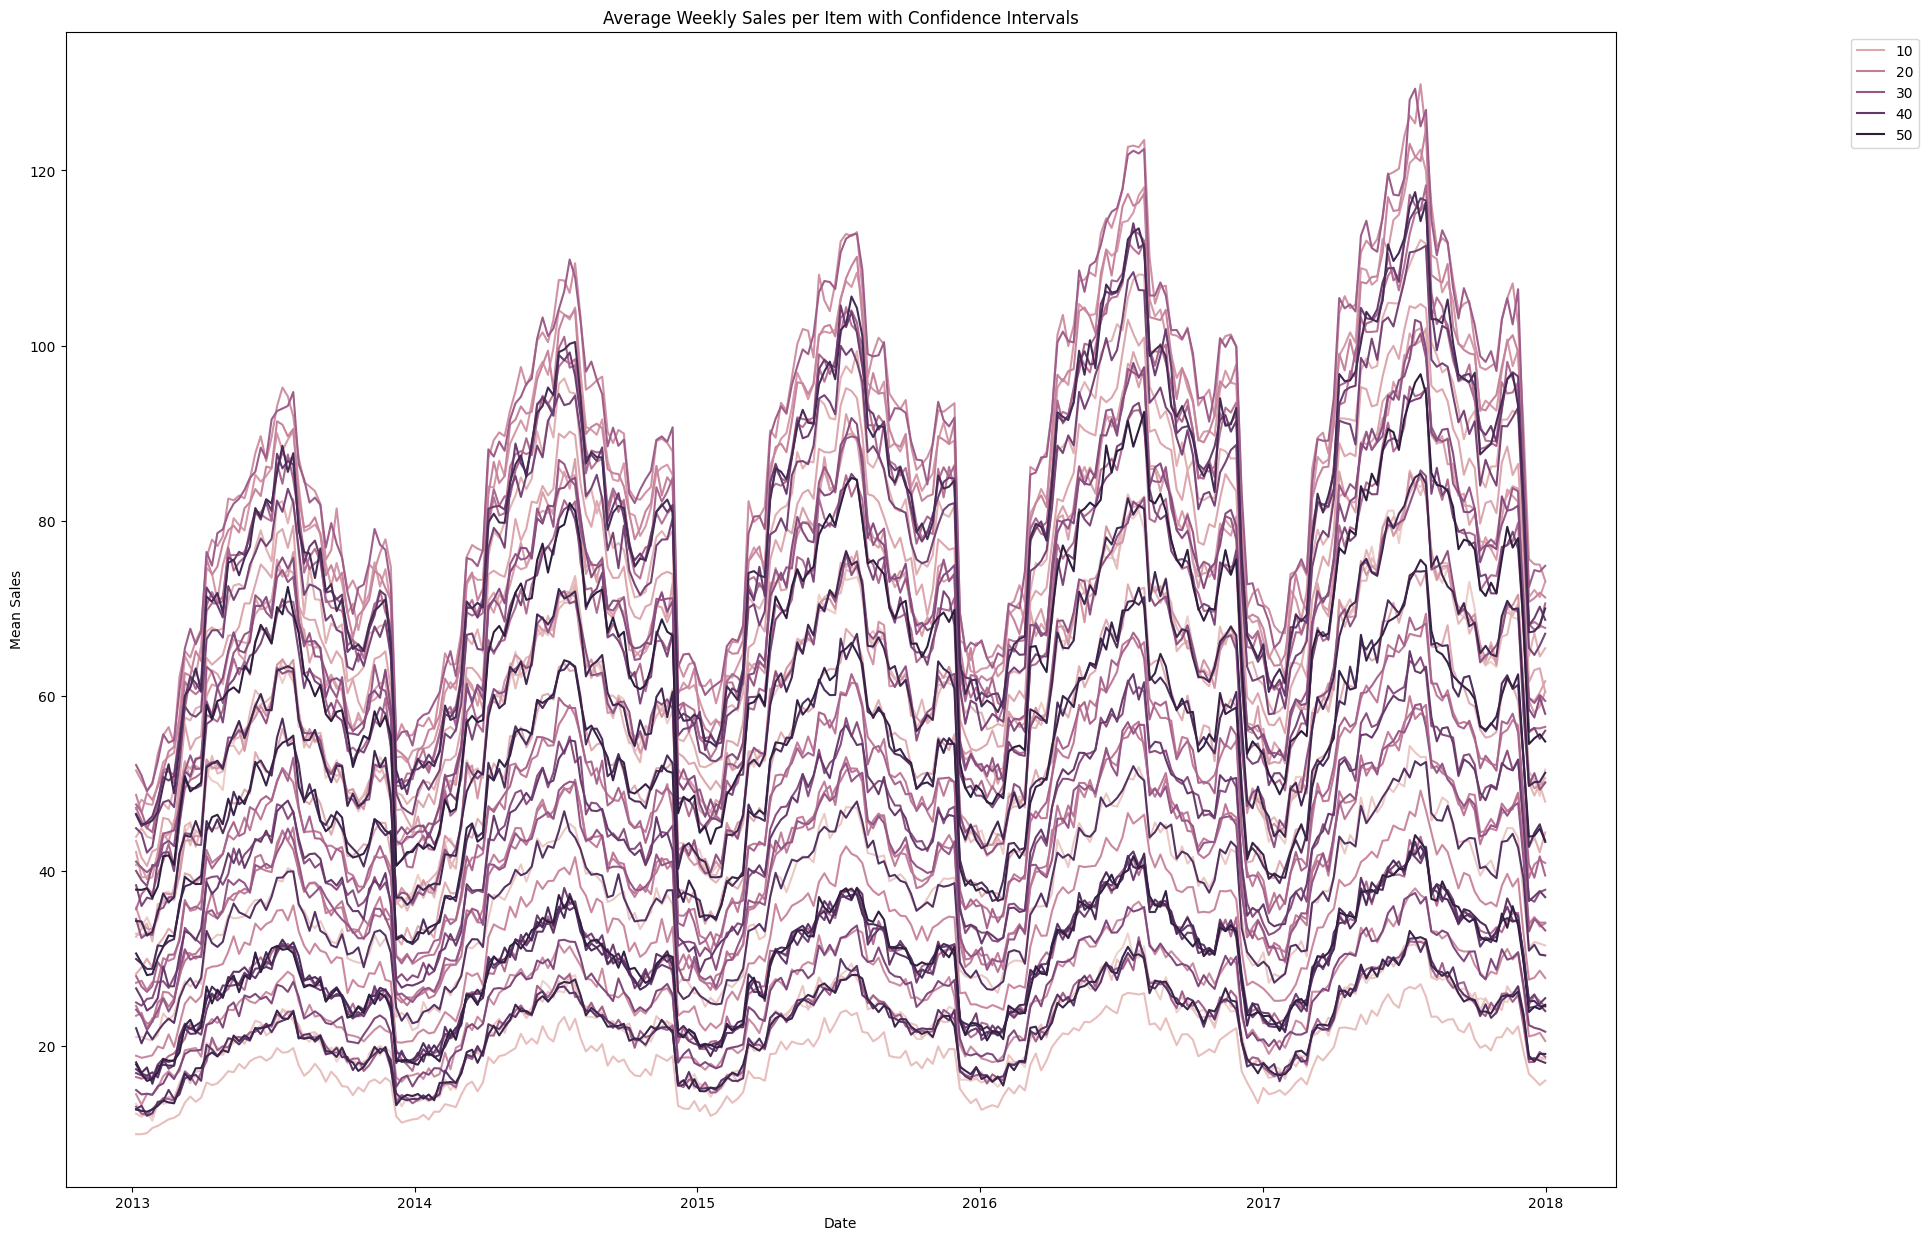

In [26]:
stores_weekly = stores_df.groupby([pd.Grouper(level=0, freq='W'), 'item'])['sales'].mean().reset_index()

plt.figure(figsize=(20, 15))
sns.lineplot(data=stores_weekly, x='date', y='sales', hue='item', estimator='mean', errorbar=('ci', 95))
plt.title("Average Weekly Sales per Item with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Mean Sales")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()


***Let's also build heatmap of item sales Accross Stores***

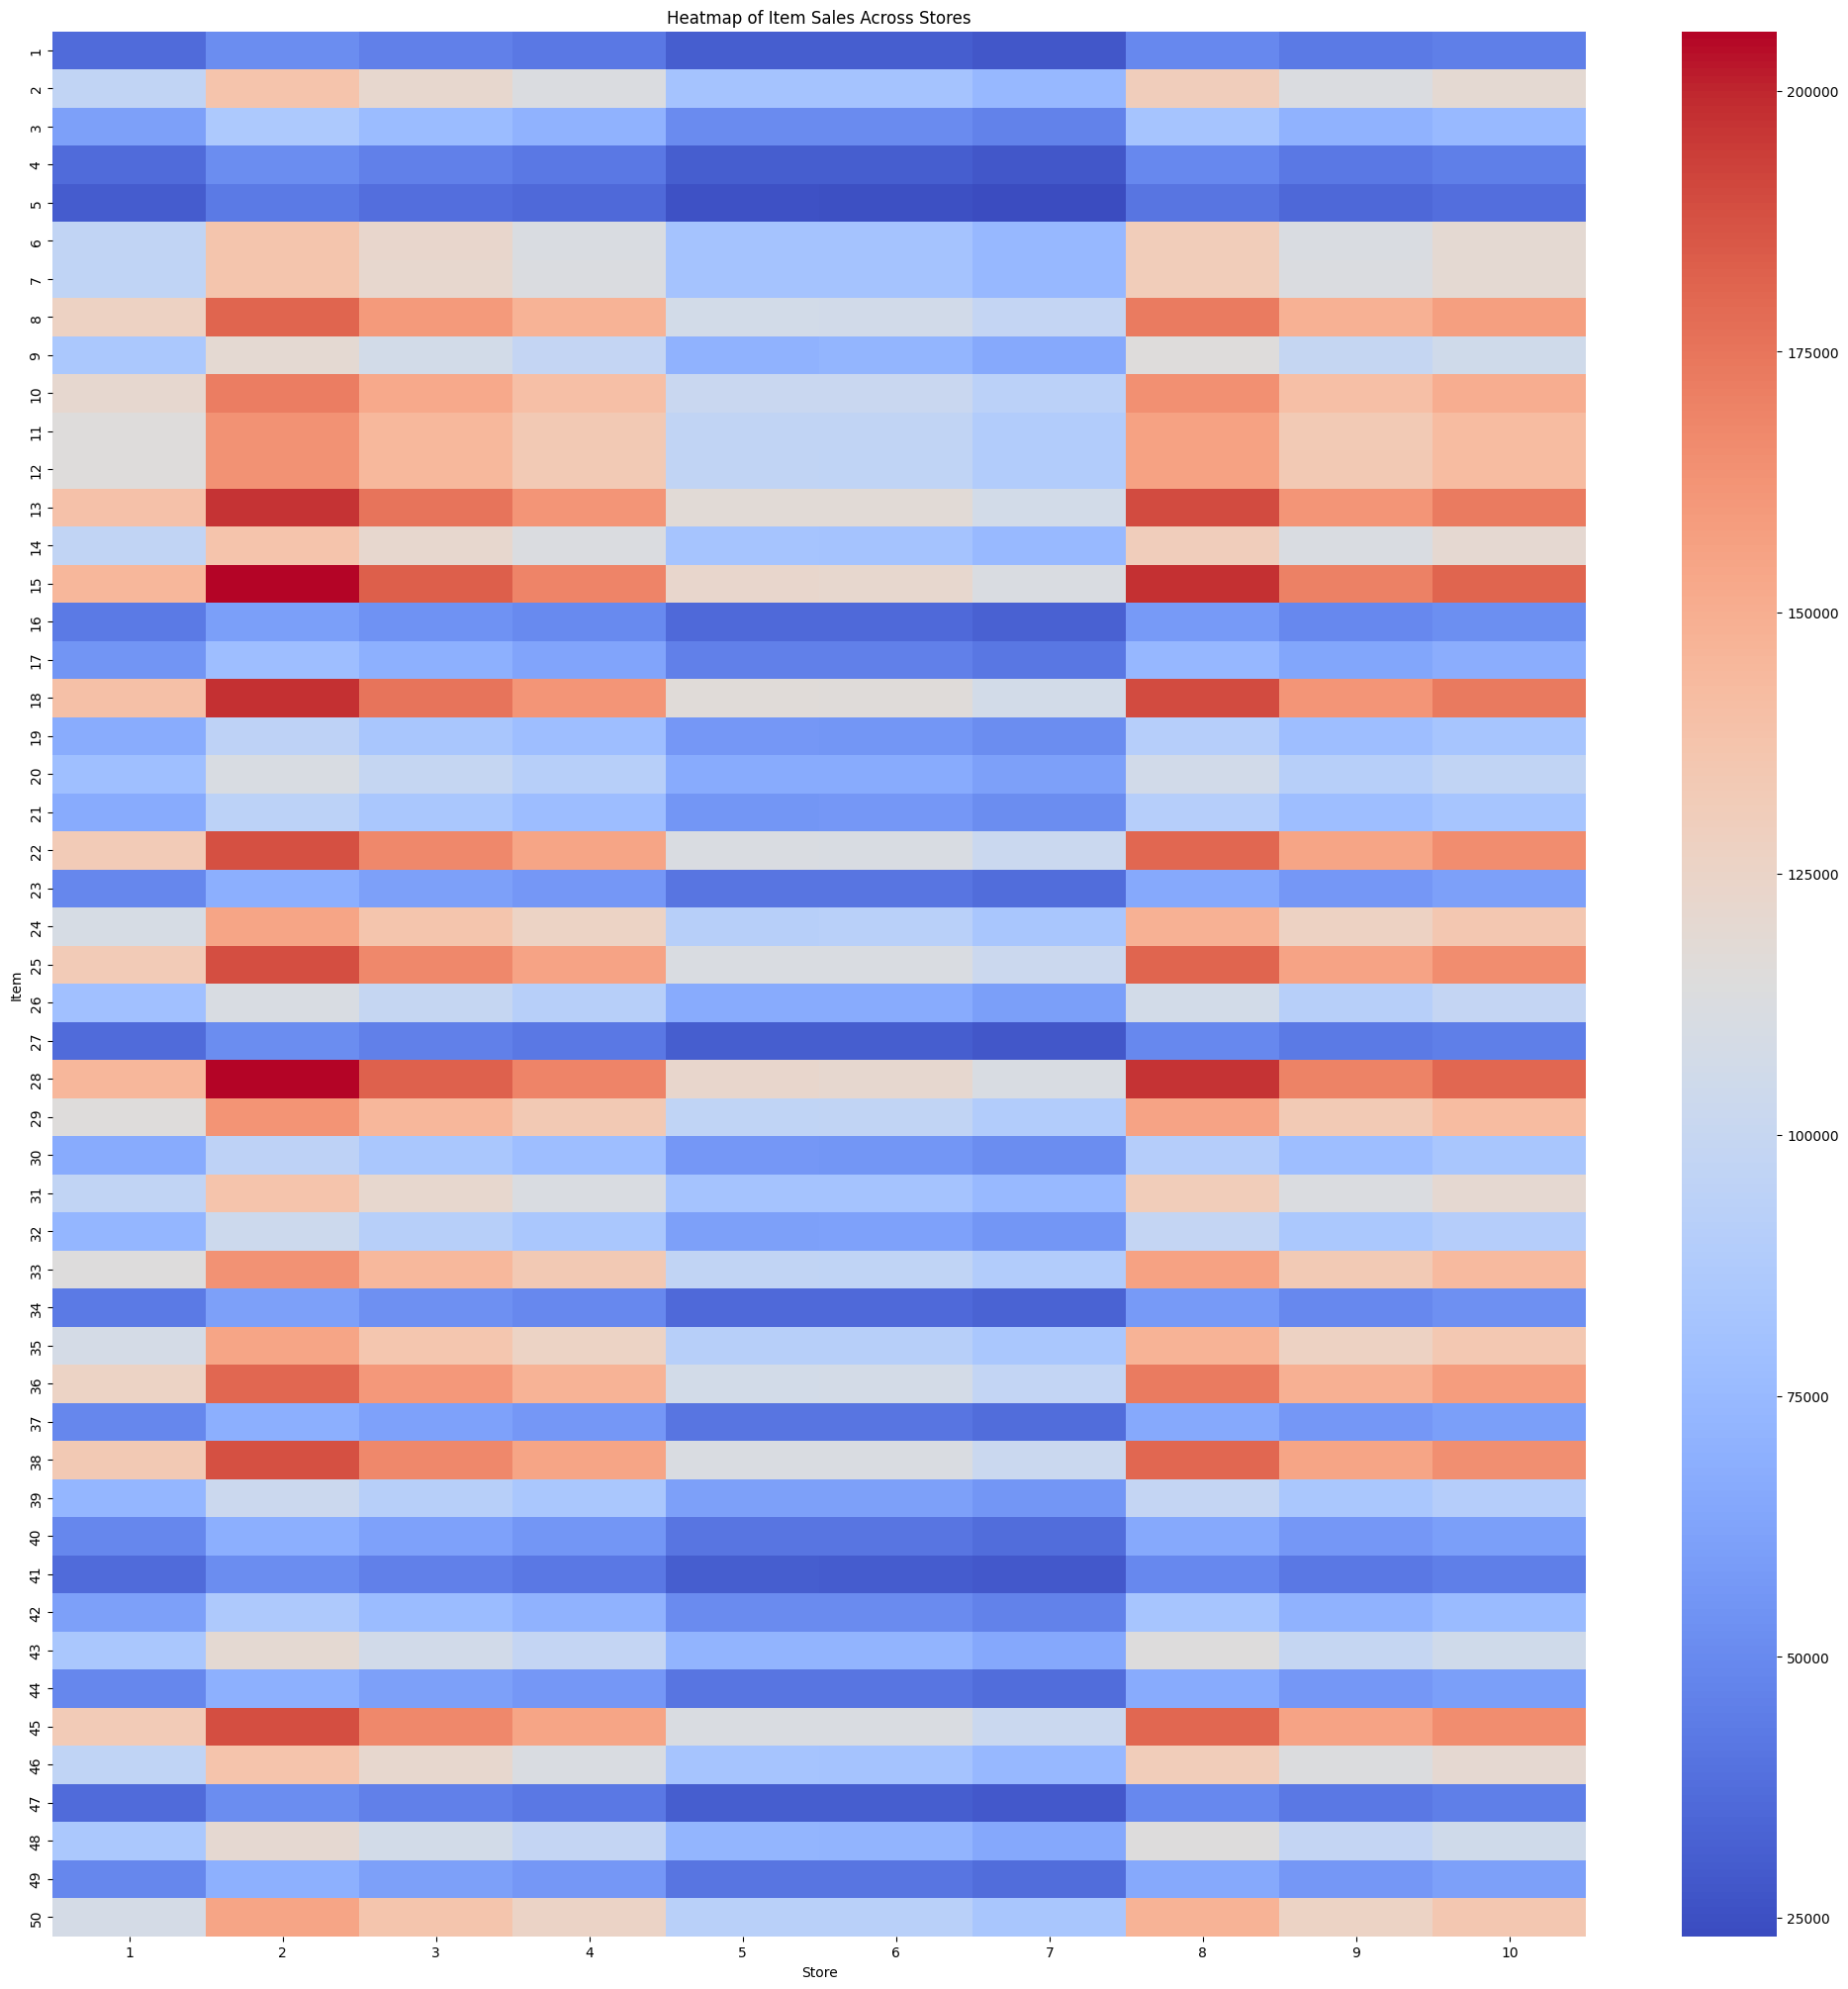

In [31]:
pivot_table = stores_df.pivot_table(index='item', columns='store', values='sales', aggfunc='sum')

plt.figure(figsize=(25, 25))
sns.heatmap(pivot_table, cmap='coolwarm', annot=False)
plt.title("Heatmap of Item Sales Across Stores")
plt.xlabel("Store")
plt.ylabel("Item")
plt.show()

***Here are my observations:***

1. First and second plot clearly show, that data has seasonality and trend.
   Seasonality may be caused by holidays, promotions and sales for example.
   Trend shows stable demand for products over time.
2. Fist and second plot are also seem to be stationary, which says that mean of sales may be relatively consistent over time.
3. Heatmap shows that sales distribution is not uniform:
   - Some stores (e.g. 2, 8, 10) have significantly higher sales for certain items.
   - Some items are not consistently sold across multiple stores.
   - Some stores sell wide variety of items
   - If some stores underperform in selling certain items, it could indicate overstocking issues
   - If some items sell explicitly well in some stores, but not others, it may be because of some regional preferences.

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

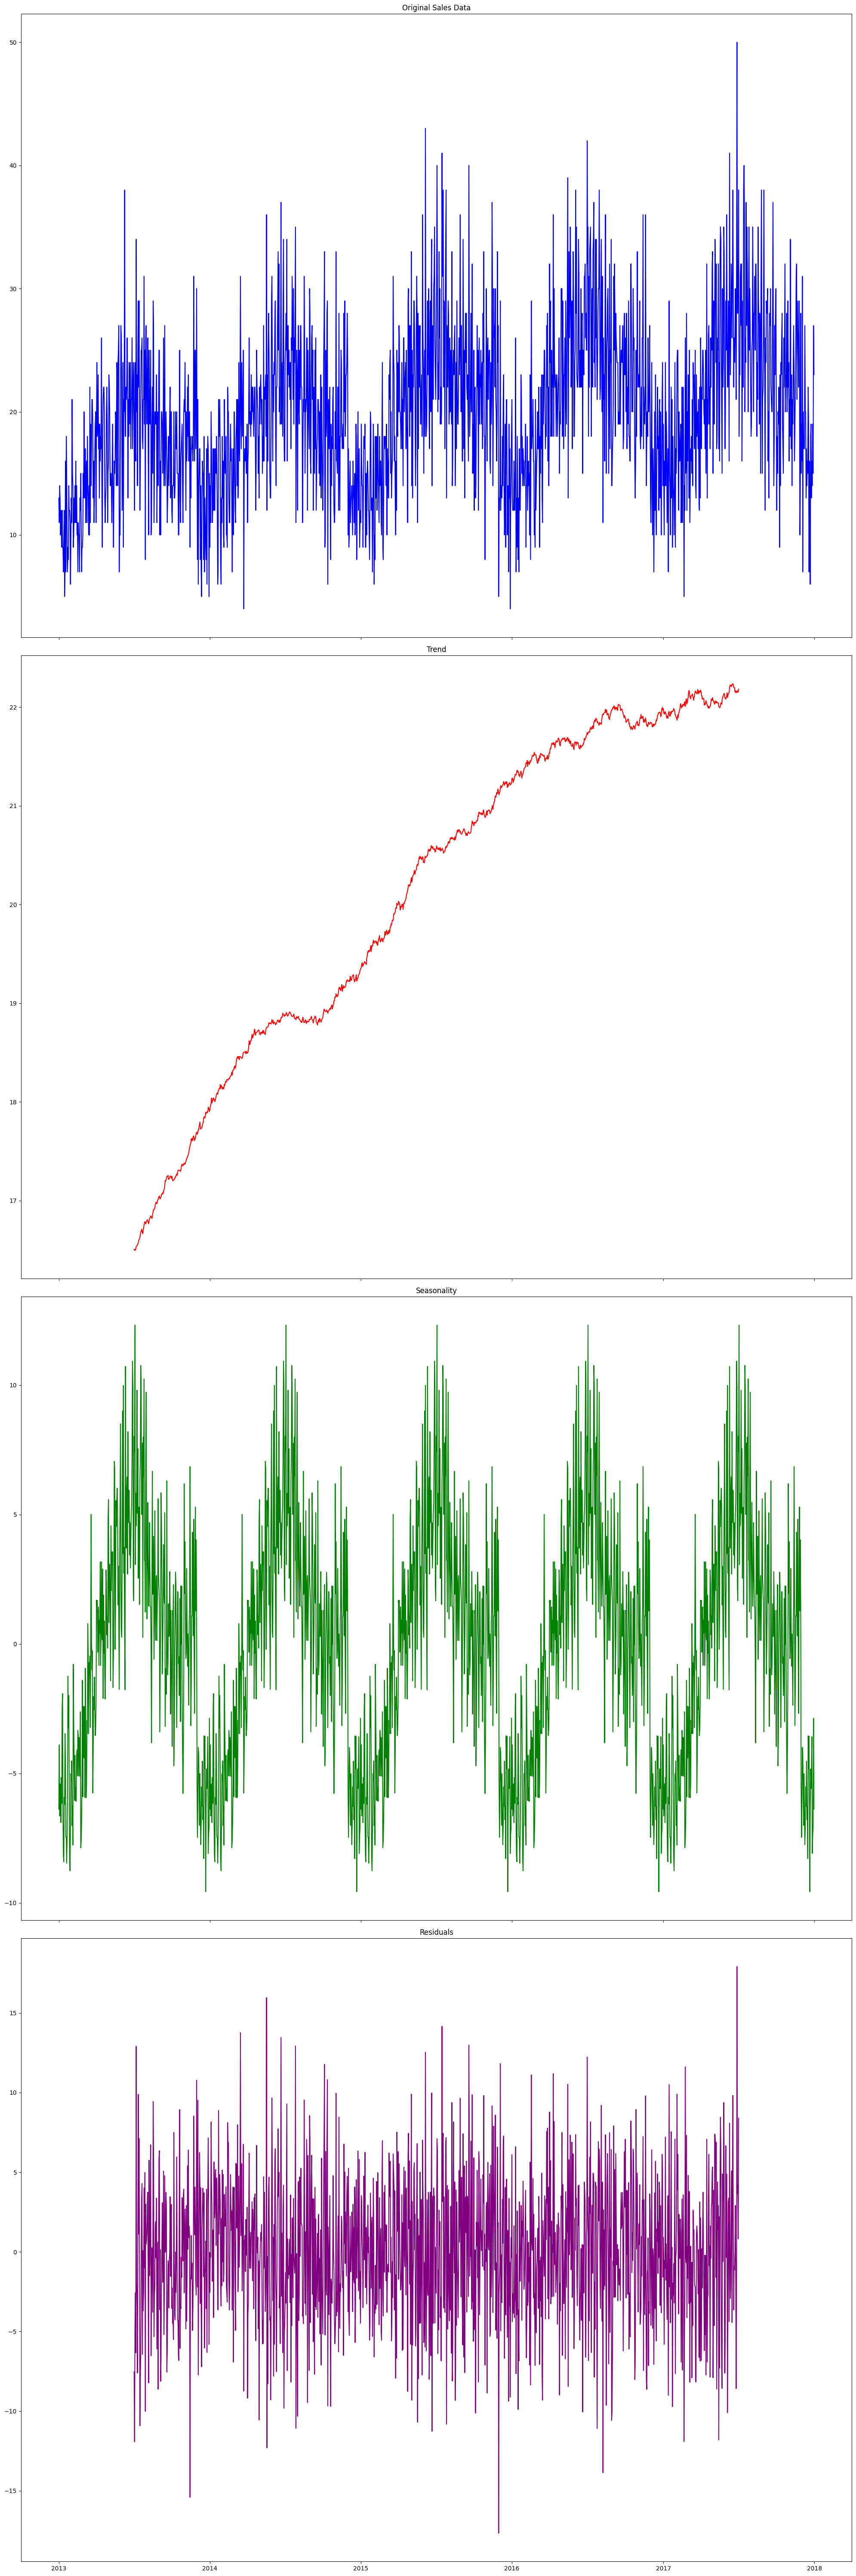

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

store_item_df = stores_df[(stores_df['item'] == 1) & (stores_df['store'] == 1)].copy()

decomposed = seasonal_decompose(store_item_df['sales'], model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(20, 60), sharex=True)
axes[0].plot(store_item_df['sales'], label='Original Sales Data', color='blue')
axes[0].set_title('Original Sales Data')

axes[1].plot(decomposed.trend, label='Trend', color='red')
axes[1].set_title('Trend')

axes[2].plot(decomposed.seasonal, label='Seasonality', color='green')
axes[2].set_title('Seasonality')

axes[3].plot(decomposed.resid, label='Residuals', color='purple')
axes[3].set_title('Residuals')

plt.tight_layout()
plt.show()




***Here are my conclusions:***
   1. Trend Analysis: The trend component shows an overall increasing pattern, meaning sales of item 1 in store 1 have been growing over time.
   2.	Seasonality: The seasonality plot indicates periodic fluctuations that repeat consistently, which suggests predictable demand changes throughout the year.
   3. Residuals: The residual component appears to be mostly random noise, without clear patterns. This means that the chosen decomposition period (365 days) effectively captures the trend and seasonality, leaving only unexplained variation.
   4. I can use apply a Dickey-Fuller test (ADF test) to confirm whether your time series is stationary.

***Let's implement ADF test***

In [37]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(store_item_df['sales'])

print('ADF results')
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical values: {adf_result[4]}")

if adf_result[1] < 0.05:
    print("The time series is stationary (reject null hypothesis)")
else:
    print("The time series is non-stationary (fail to reject null hypothesis)")

ADF results
ADF Statistic: -3.1576705563328202
p-value: 0.022569380626570476
Critical values: {'1%': -3.4339840952648695, '5%': -2.8631452508003057, '10%': -2.567624583142913}
The time series is stationary (reject null hypothesis)


4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [38]:
from darts import TimeSeries

ts = TimeSeries.from_dataframe(store_item_df, value_cols='sales')

print(ts)

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) <U5 20B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None


5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

14. Натренуйте модель Prophet та зробіть висновок про її якість.

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.